# Imports

In [40]:
import numpy as np
import gym
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Environment

Taxi: https://gymnasium.farama.org/environments/toy_text/taxi/

# Agent class

In [41]:
class Agent:
    def __init__(self, env, alpha, gamma):
        self.env = env

        not_pr_acts = 2 + 1 + 1 + 1  # Non primitive actions: navigate(source), navigate(destination), get passenger, drop passenger, root
        nA = env.action_space.n + not_pr_acts  # Total number of actions
        nS = env.observation_space.n # Total number of states
        self.V = np.zeros((nA, nS))  # Value function
        self.C = np.zeros((nA, nS, nA))  # Completion function
        self.V_copy = self.V.copy()

        # Numbering the actions
        s = self.south = 0
        n = self.north = 1
        e = self.east = 2
        w = self.west = 3
        pickup = self.pickup = 4
        dropoff = self.dropoff = 5
        gotoS = self.gotoS = 6
        gotoD = self.gotoD = 7
        get = self.get = 8
        put = self.put = 9
        root = self.root = 10

        self.graph = [
            set(),  # south
            set(),  # north
            set(),  # east
            set(),  # west
            set(),  # pickup
            set(),  # dropoff
            {s, n, e, w},  # gotoSource
            {s, n, e, w},  # gotoDestination
            {pickup, gotoS},  # get -> pickup, gotoSource
            {dropoff, gotoD},  # put -> dropoff, gotoDestination
            {put, get},  # root -> put, get
        ]

        self.alpha = alpha
        self.gamma = gamma
        self.r_sum = 0
        self.new_s = copy.copy(self.env.s)
        self.done = False
        self.num_of_ac = 0

    def is_primitive(self, act):
        if act <= 5:
            return True
        else:
            return False

    def is_terminal(self, a, done):
        RGBY = [(0, 0), (0, 4), (4, 0), (4, 3)]
        taxirow, taxicol, passidx, destidx = list(self.env.decode(self.env.s))
        taxiloc = (taxirow, taxicol)
        if done:
            return True
        elif a == self.root:
            return done
        elif a == self.put:
            return passidx < 4 # At location
        elif a == self.get:
            return passidx >= 4 # Within taxi
        elif a == self.gotoD:
            return passidx >= 4 and taxiloc == RGBY[destidx]  # Primitive dropoff after this
        elif a == self.gotoS:
            return passidx < 4 and taxiloc == RGBY[passidx]  # Primitive pickup after this
        elif self.is_primitive(a):
            return True


    def evaluate(self, act, s):
            if self.is_primitive(act):
                return self.V_copy[act, s]
            else:
                for j in self.graph[act]:
                    self.V_copy[j, s] = self.evaluate(j, s)
                Q = np.arange(0) # Empty array
                for a2 in self.graph[act]:
                    Q = np.concatenate((Q, [self.V_copy[a2, s]]))
                max_arg = np.argmax(Q)
                return self.V_copy[max_arg, s]


    # Epsilon-greedy action selection with epsilon = 0.001
    def greed_act(self, act, s):
        e = 0.001
        Q = np.arange(0)
        possible_a = np.arange(0)
        for act2 in self.graph[act]:
            if self.is_primitive(act2) or (not self.is_terminal(act2, self.done)):
                Q = np.concatenate((Q, [self.V[act2, s] + self.C[act, s, act2]]))
                possible_a = np.concatenate((possible_a, [act2]))
        max_arg = np.argmax(Q)
        if np.random.rand(1) < e:
            return np.random.choice(possible_a)
        else:
            return possible_a[max_arg]


    def MAXQ_0(self, i, s):  # i is action number
        if self.done:
            i = 11  # To end recursion
        self.done = False
        if self.is_primitive(i):
            self.new_s, r, self.done, _ = copy.copy(self.env.step(i)) # Take action in environment
            self.r_sum += r
            self.num_of_ac += 1
            self.V[i, s] += self.alpha * (r - self.V[i, s])  # Value update
            return 1
        elif i <= self.root:  # Non primitive actions
            count = 0
            while not self.is_terminal(i, self.done):
                a = self.greed_act(i, s)  # a is new action num
                N = self.MAXQ_0(a, s)  # N denotes tau
                self.V_copy = self.V.copy()
                evaluate_res = self.evaluate(i, self.new_s)
                self.C[i, s, a] += self.alpha * (self.gamma ** N * evaluate_res - self.C[i, s, a])
                count += N
                s = self.new_s
            return count


    def reset(self):
        self.env.reset()
        self.r_sum = 0
        self.num_of_ac = 0
        self.done = False
        self.new_s = copy.copy(self.env.s)

# Hyperparameters

In [42]:
alpha = 0.2 # Learning rate
gamma = 1 # Discount factor
episodes = 5001 # Number of episodes

In [43]:
env = gym.make('Taxi-v3').env
env.reset()
taxi = Agent(env, alpha, gamma) # Creating object of Agent class

# Training

In [44]:
rew_list = [] # List to store episode rewards
for j in range(episodes):
    taxi.reset()
    taxi.MAXQ_0(10, env.s)      # Start in root
    rew_list.append(taxi.r_sum)
    if (j % 1000 == 0):
        print('Completed', j, 'episodes')

Completed 0 episodes
Completed 1000 episodes
Completed 2000 episodes
Completed 3000 episodes
Completed 4000 episodes
Completed 5000 episodes


# Plotting

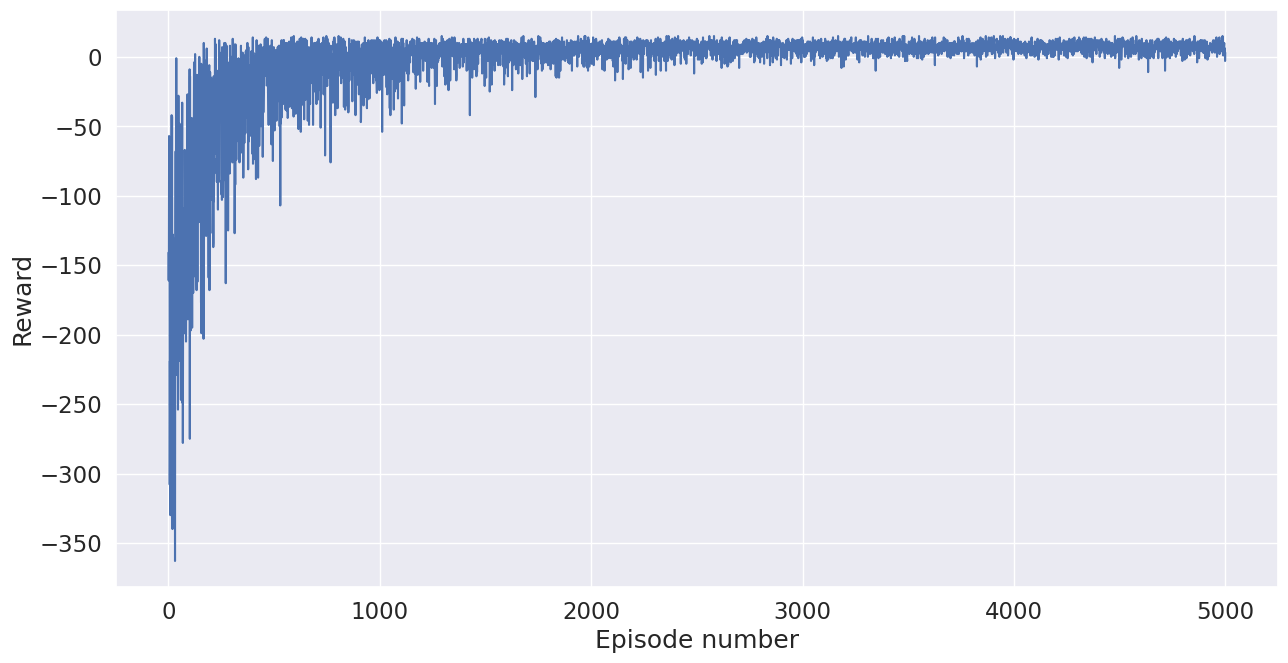

In [45]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.figure(figsize=(15, 7.5))
plt.plot(rew_list)
plt.xlabel('Episode number')
plt.ylabel('Reward')
plt.show()

# Further experiments:

1. Different hyperparameters
2. Different exploration policy: decay, softmax etc.
3. Different variants of Taxi
4. Different environments
5. MAXQ_QLearning using pseudo rewards
6. Options and HAM